# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import qnm
from gwpy.timeseries import TimeSeries
import copy
from scipy.special import logsumexp
import astropy.constants as c

## Data

In [5]:
omega, A, C = qnm.modes_cache(s=-2, l=2, m=2, n=0)(a=0.69)
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

(0.245, 0.265)

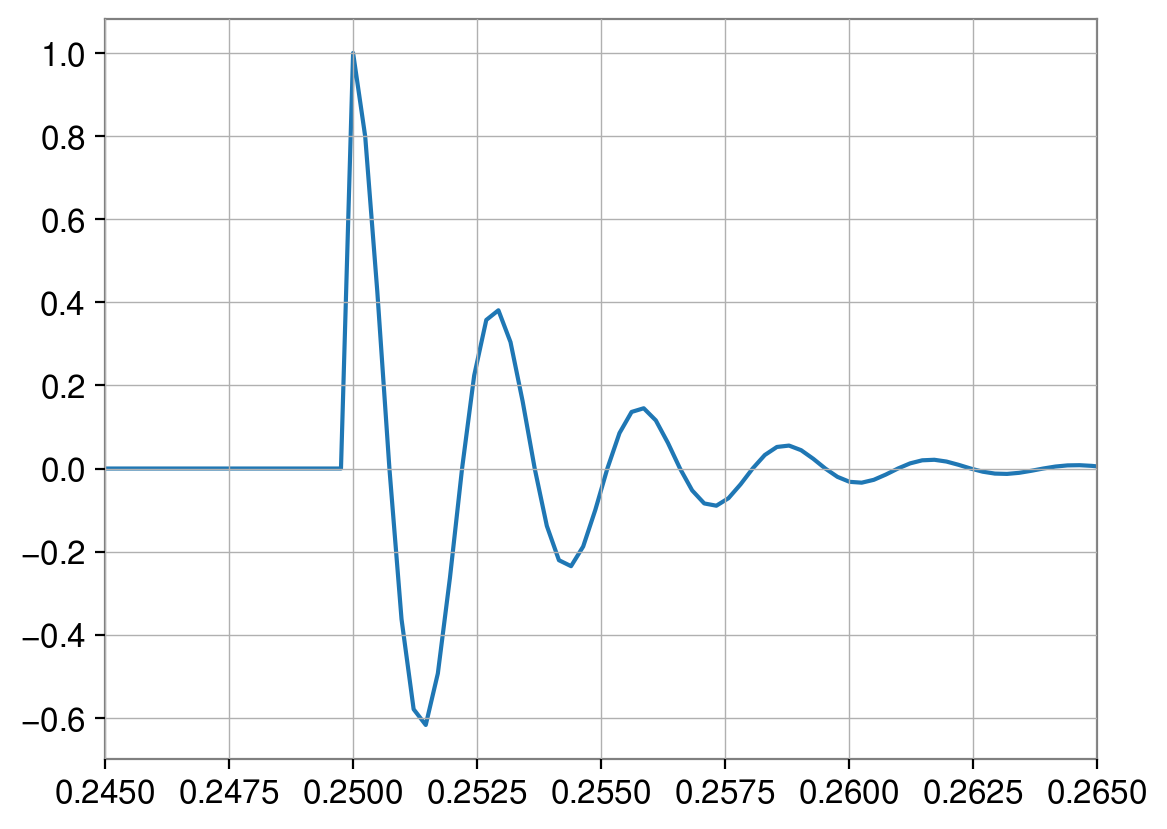

In [10]:
srate = 4096
t_range_prepad = np.linspace(0,0.5, int(srate/2), endpoint = False)
heaviside = np.heaviside(t_range_prepad, 1)
temp = np.exp(-1j*omega*t_range_prepad/(50*T_MSUN))
signal_prepad = np.real(temp*heaviside)
t_range = np.linspace(0,1, srate, endpoint = False)
signal = np.pad(signal_prepad, (int(srate/4),int(srate/4)))
noise = 0

data = signal + noise
pl.plot(t_range, data)
pl.xlim(0.245, 0.265)

## Filter

In [11]:
input = dict(model_list = [(2,2,0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 0.25, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = None, dec = None,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [12]:
fit.original_data['H1'] = qnm_filter.RealData(data, index = )

NameError: name 'H_waveform' is not defined

In [59]:
fit.detector_alignment()
fit.condition_data('original_data', **input, trim = 0.0)
fit.compute_acfs('original_data')

In [60]:
temp_acf = np.full(input['srate'], 0, dtype = np.double)
temp_acf[0] = 1.1*1e-22**2
fit.acfs['H1'] = qnm_filter.Data(temp_acf, index = fit.acfs['H1'].index)
fit.cholesky_decomposition()

In [61]:
fit.first_index()
template = fit.truncate_data(fit.original_data)['H1']

In [62]:
fit.compute_SNR(0, template, 'H1', optimal=True)

7.729202739470843

In [63]:
delta_mass = 1.0
delta_chi = 0.05
massspace = np.arange(34, 140, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [64]:
fit.first_index()
likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

/home/neil/anaconda3/envs/ringdown/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [65]:
credible_region = qnm_filter.find_credible_region(likelihood_data, target_probability=0.9)

In [66]:
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

In [67]:
average_mass = np.dot(projected_mass, massspace)
average_chi = np.dot(projected_chi, chispace)
MAP_idx = np.argmax(likelihood_data)
MAP_value = (mass_grid.reshape(-1)[MAP_idx], chi_grid.reshape(-1)[MAP_idx])

In [68]:
filters_str = '+'.join([''.join(str(i) for i in j) for j in input['model_list']])
time_str = str(np.round((input['t_init'] - SSB_peak_time)/mass_unit, 2))

In [69]:
def epsilon_calc(mass_err, chi_err, mass_theoretical, chi_theoretical):
    temp0 = chi_err**2
    temp1 = (mass_err/mass_theoretical)**2
    return np.sqrt(temp0+temp1)

In [70]:
average_epsilon = epsilon_calc(average_mass - theoretical_values[0], average_chi - theoretical_values[1],
                   theoretical_values[0], theoretical_values[1])
MAP_epsilon = epsilon_calc(MAP_value[0] - theoretical_values[0], MAP_value[1] - theoretical_values[1],
                   theoretical_values[0], theoretical_values[1])

Text(105, 0.1, 'ln(evidence) = 4.18')

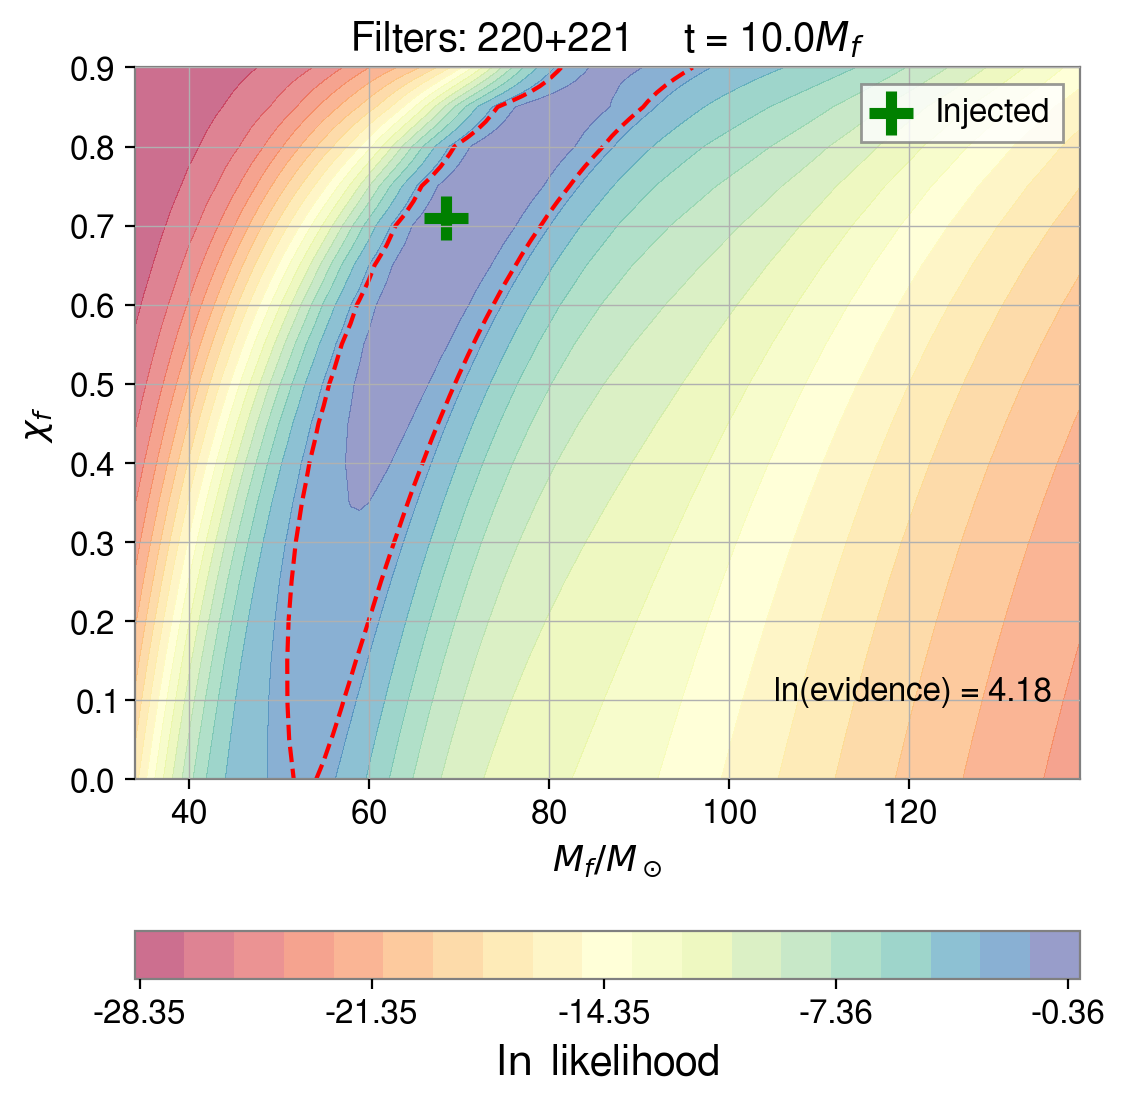

In [71]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=theoretical_values[0], y=theoretical_values[1], s=255, marker='+', 
           c='g', linewidths=4, label='Injected')
# ax.scatter(x=average_mass, y=average_chi, s=255, marker='+', 
#            c='r', linewidths=4, label='weighted average')
# ax.scatter(x=MAP_value[0], y=MAP_value[1], s=255, marker='+', 
#            c='y', linewidths=4, label='MAP')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend()
ax.set_title("Filters: " + filters_str + "     t = " + time_str + r'$M_f$')
ax.text(105, 0.1, 'ln(evidence) = %.2f' % (logsumexp(likelihood_data)))
# ax.text(118, 0.1, '$\epsilon_{MAP} = %.2f$' '\n' '$\epsilon_{avg} = %.2f$' % (MAP_epsilon, average_epsilon))